In [3]:
import pandas as pd
import utilsNb as utils
import torch
import transformers

from sklearn.metrics import classification_report
from transformers import pipeline
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformers.logging.set_verbosity_error()

# reload modules
%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# df = pd.read_csv("../data/final_test_esg2.csv")
df = pd.read_csv("./pv_2312/pv_2312_512_hf.csv", encoding="utf-8")
df

,section_number,text,esg_category
0,1,1. \n\nAppel : \n\n93 Conseillères et Conseil...,non-esg
1,2,2. \n\nProcès-verbal de la séance du 13 novemb...,non-esg
2,3,3. \n\nApprobation de l’ordre du jour \n\nM. l...,gouvernance
3,4,4. \n\nCommunications du Bureau \n\n• M. le ...,gouvernance
4,4,• M. le Président était également satisfait d...,gouvernance
...,...,...,...
159,20,Je tiens à remercier très sincèrement mes coll...,non-esg
160,20,Notre compliment à Marco Carenza qui a parfait...,non-esg
161,20,Malgré une situation financière qui reste préo...,environnemental
162,20,De nombreux projets – dont on parle depuis lon...,non-esg


# Finetuned models

The following models have been finetuned on the dataset "*esg_fr_classification.csv*". Analysis of the dataset can be found in the separate notebook *dataset_analysis.ipynb* 

In [8]:
model_cbl, tokenizer_large = utils.load_sd_model("cbl-512",model_sd_path='../models/model-cbl/run1/models/state_dict/cb_large_model1_sd.pt') 
model_cbl_1024, _ = utils.load_sd_model("cbl-1024",model_sd_path='../models/model-cbl-long/run1/models/state_dict/cbl_model_long_sd.pt')
model_cb, tokenizer_base = utils.load_sd_model("cb-512",model_sd_path='../models/model-cb/run1/models/state_dict/model_cb_sd.pt')
model_cb_1024, _ = utils.load_sd_model("cb-1024",model_sd_path='../models/model-cb-long/run1/models/state_dict/camembert_long_state_dict.pt')

Model cbl-512 loaded.
Model cbl-1024 loaded.
Model cb-512 loaded.
Model cb-1024 loaded.


## Model Camembert-base-512

100%|██████████| 164/164 [00:25<00:00,  6.42it/s]


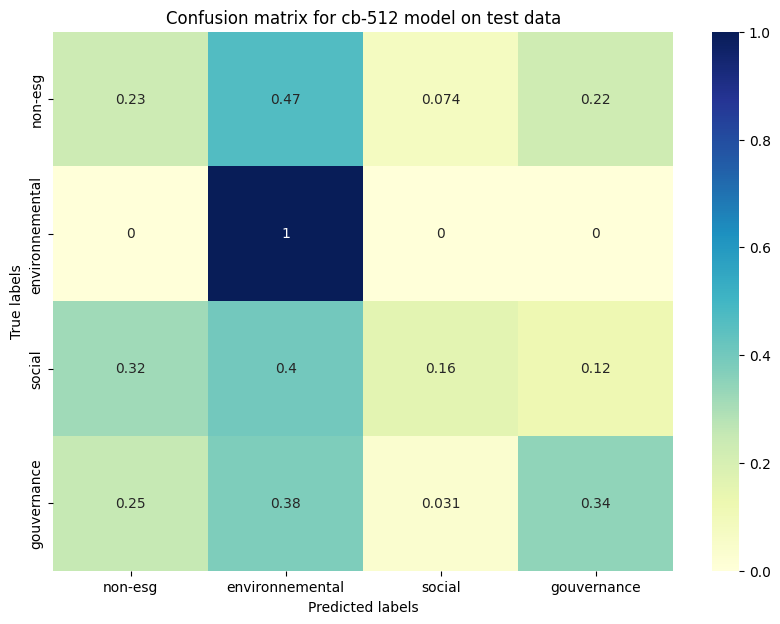

                 precision    recall  f1-score   support

environnemental       0.16      1.00      0.28        13
    gouvernance       0.31      0.34      0.33        32
        non-esg       0.58      0.23      0.33        94
         social       0.33      0.16      0.22        25

       accuracy                           0.30       164
      macro avg       0.35      0.43      0.29       164
   weighted avg       0.46      0.30      0.31       164



In [9]:
df_res = utils.predict_df(df, model_cb, tokenizer_base, tokenizer_max_len=512, return_prediction_only=True, column_name="cb_pred")

utils.print_confusion_matrix(df_res["esg_category"], df_res['cb_pred'], title = "Confusion matrix for cb-512 model on test data")
report = classification_report(df_res['esg_category'], df_res['cb_pred'], zero_division=0)
print(report)

## Model Camembert-large-512 

In [10]:
df_res = utils.predict_df(df_res, model_cbl, tokenizer_large, tokenizer_max_len=512, return_prediction_only=True, column_name="cbl_pred")

100%|██████████| 164/164 [01:09<00:00,  2.37it/s]


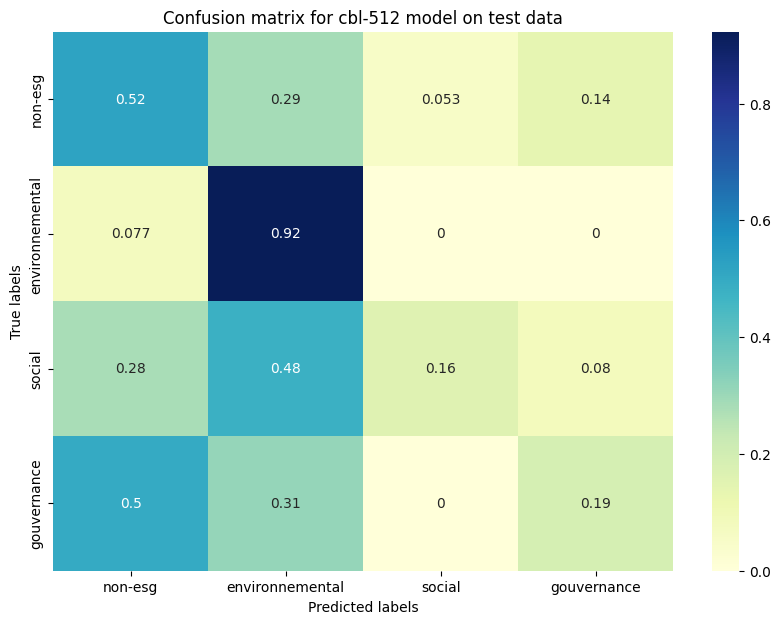

                 precision    recall  f1-score   support

environnemental       0.20      0.92      0.32        13
    gouvernance       0.29      0.19      0.23        32
        non-esg       0.67      0.52      0.59        94
         social       0.44      0.16      0.24        25

       accuracy                           0.43       164
      macro avg       0.40      0.45      0.34       164
   weighted avg       0.52      0.43      0.44       164



In [11]:
utils.print_confusion_matrix(df_res["esg_category"], df_res['cbl_pred'], title = "Confusion matrix for cbl-512 model on test data")
report = classification_report(df_res['esg_category'], df_res['cbl_pred'], zero_division=0)
print(report)

## Model Camembert-large-1024 

In [12]:
df_res = utils.predict_df(df_res, model_cbl_1024, tokenizer_large, tokenizer_max_len=1024, return_prediction_only=True, column_name="cbl_1024_pred")

100%|██████████| 164/164 [01:09<00:00,  2.35it/s]


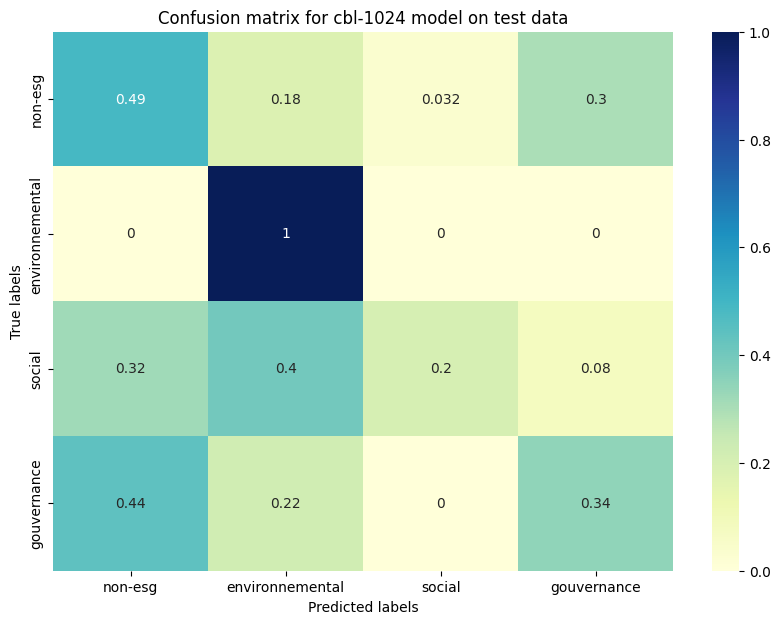

                 precision    recall  f1-score   support

environnemental       0.28      1.00      0.43        13
    gouvernance       0.27      0.34      0.30        32
        non-esg       0.68      0.49      0.57        94
         social       0.62      0.20      0.30        25

       accuracy                           0.46       164
      macro avg       0.46      0.51      0.40       164
   weighted avg       0.56      0.46      0.46       164



In [13]:
utils.print_confusion_matrix(df["esg_category"], df_res['cbl_1024_pred'], title = "Confusion matrix for cbl-1024 model on test data")
report = classification_report(df['esg_category'], df_res['cbl_1024_pred'], zero_division=0)
print(report)

# Zero-shot models

Zero-shot classification is performed using the following models:

<!-- add urls -->



In [16]:
ESG_DICT = {
    "environnemental": ["changement climatique", "capital naturel", "pollution et déchets", "Opportunités environnementales"],
    "social": ["capital humain", "responsabilité du produit", "opposition des parties prenantes", "opportunités sociales", "services publiques"],
    "gouvernance": ["gouvernance d'entreprises", "comportement d'entreprises"],
    "non-esg": ["autre","divertissement"]
}
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")


def predict_sample(sample, candidate_labels, top_k = 3, return_all = False):
    output = classifier(sample, candidate_labels, multi_label=False)
    output_df = pd.DataFrame(output)[["labels", "scores"]][:top_k]
    # find the key from the esg_dict
    output_df["key_label"] = output_df["labels"].apply(lambda x: [key for key, value in ESG_DICT.items() if x in value][0])

    count_dict = {}
    for label in output_df["key_label"]:
        count_dict[label] = count_dict.get(label, 0) + 1

    best_choice = max(count_dict, key=count_dict.get)

    if return_all: return output_df, best_choice

    return best_choice

CANDIDATE_LABELS = list(ESG_DICT.values())
CANDIDATE_LABELS = [item for sublist in CANDIDATE_LABELS for item in sublist]

## MoritzLaurer/mDeBERTa-v3-base-mnli-xnli

In [17]:
df_res['0-shot'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    df_res.at[i,'0-shot'] = predict_sample(row['text'], CANDIDATE_LABELS)
    
debert_base_preds = df_res['0-shot']

100%|██████████| 164/164 [15:58<00:00,  5.85s/it]


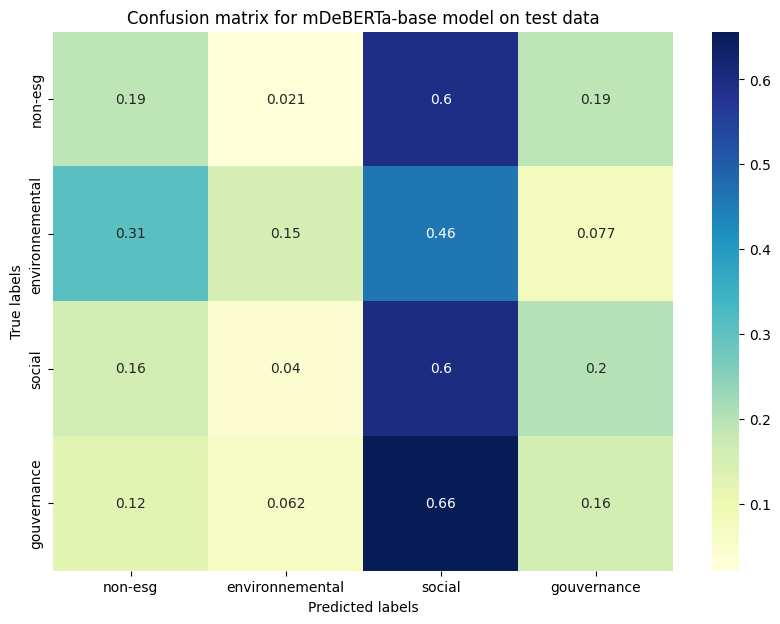

                 precision    recall  f1-score   support

environnemental       0.29      0.15      0.20        13
    gouvernance       0.17      0.16      0.16        32
        non-esg       0.60      0.19      0.29        94
         social       0.15      0.60      0.24        25

       accuracy                           0.24       164
      macro avg       0.30      0.28      0.22       164
   weighted avg       0.42      0.24      0.25       164



In [19]:
utils.print_confusion_matrix(df["esg_category"], debert_base_preds, title = "Confusion matrix for mDeBERTa-base model on test data")
print(classification_report(df['esg_category'], debert_base_preds, zero_division=0))

## MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33

In [20]:
from transformers import pipeline
from easynmt import EasyNMT
import warnings
warnings.filterwarnings('ignore')

pipe = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33")
model = EasyNMT('opus-mt',cache_folder="./NMT_model_cache")

In [ ]:
df_res['0-shot-EN'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    fr_text = row['text']
    en_text = model.translate(fr_text, source_lang='fr', target_lang='en')
    df_res.at[i,'0-shot-EN'] = predict_sample(en_text, CANDIDATE_LABELS)

debert_large_preds = df_res['0-shot-EN']

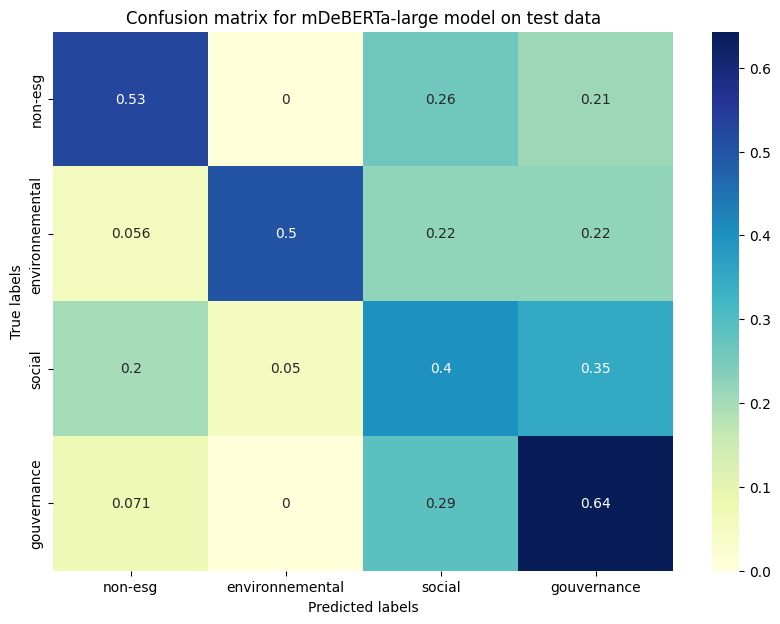

                 precision    recall  f1-score   support

environnemental       0.90      0.50      0.64        18
    gouvernance       0.38      0.64      0.47        14
        non-esg       0.62      0.53      0.57        19
         social       0.38      0.40      0.39        20

       accuracy                           0.51        71
      macro avg       0.57      0.52      0.52        71
   weighted avg       0.58      0.51      0.52        71



In [ ]:
utils.print_confusion_matrix(df["esg_category"], debert_large_preds, title = "Confusion matrix for mDeBERTa-large model on test data")
print(classification_report(df['esg_category'], debert_large_preds, zero_division=0))

# Weighted Average prediction by  *ensemble learning*

In [14]:
df_res

,section_number,text,esg_category,cb_pred,cbl_pred,cbl_1024_pred
0,1,1. \n\nAppel : \n\n93 Conseillères et Conseil...,non-esg,environnemental,non-esg,gouvernance
1,2,2. \n\nProcès-verbal de la séance du 13 novemb...,non-esg,gouvernance,non-esg,non-esg
2,3,3. \n\nApprobation de l’ordre du jour \n\nM. l...,gouvernance,non-esg,non-esg,non-esg
3,4,4. \n\nCommunications du Bureau \n\n• M. le ...,gouvernance,gouvernance,gouvernance,gouvernance
4,4,• M. le Président était également satisfait d...,gouvernance,environnemental,non-esg,gouvernance
...,...,...,...,...,...,...
159,20,Je tiens à remercier très sincèrement mes coll...,non-esg,environnemental,non-esg,non-esg
160,20,Notre compliment à Marco Carenza qui a parfait...,non-esg,environnemental,non-esg,environnemental
161,20,Malgré une situation financière qui reste préo...,environnemental,environnemental,environnemental,environnemental
162,20,De nombreux projets – dont on parle depuis lon...,non-esg,environnemental,non-esg,non-esg


In [ ]:
weights = [
    [0.2, 0.1,0.7,0.1], # cbl
    [0.7,0.1,0.1,0.8], # cbl-1024
    [0.1,0.8,0.2,0.1], # cb
]
# weights = [
#     [0.2, 0.1,0.2,0.1], # cbl
#     [0.7,0.1,0.3,0.8], # cbl-1024
#     [0.1,0.8,0.5,0.1], # cb
#     # [0.2,0.2,0.2,0.1] # debert-large
# ]

# order of weights: non-esg, environnemental, social, gouvernance


df_res['agg_pred'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    cbl_pred = row['cbl_pred']
    cbl_1024_pred = row['cbl_1024_pred']
    cb_pred = row['cb_pred']
    # debert_base_pred = row['0-shot']
    # debert_large_pred = row['0-shot-EN']
    
    # preds = [cbl_pred, cbl_1024_pred, debert_base_pred, debert_large_pred]
    preds = [cbl_pred, cbl_1024_pred, cb_pred]
    
    pred_dict = {
        "non-esg": 0,
        "environnemental": 0,
        "social": 0,
        "gouvernance": 0
    }
    
    
    pred_dict[cbl_pred] += weights[0][list(pred_dict.keys()).index(cbl_pred)]
    pred_dict[cbl_1024_pred] += weights[1][list(pred_dict.keys()).index(cbl_1024_pred)]
    pred_dict[cb_pred] += weights[2][list(pred_dict.keys()).index(cb_pred)]
    # pred_dict[debert_large_pred] += weights[3][list(pred_dict.keys()).index(debert_large_pred)]
    
    best_pred = max(pred_dict, key=pred_dict.get)
    df_res.at[i,'agg_pred'] = best_pred
    
agg_preds = df_res['agg_pred']

utils.print_confusion_matrix(df["esg_category"], agg_preds, title = "Confusion matrix for the aggregated model on test data")
print(classification_report(df['esg_category'], agg_preds, zero_division=0))


In [ ]:
# export only df_res[section_number, text,agg_pred] to csv
df_res[["section_number", "text", "agg_pred"]].to_csv("pv_2312/pv_2312_512_agg_preds.csv", index=False, encoding="utf-8")
